In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from torch.utils.data import DataLoader
from generation.data.data_simulation import Nakagami
from generation.data.dataset_pytorch import SignalsDataset
from generation.train.vanila_gan import run_train, generate_new_signal
from scipy import signal
from sklearn.linear_model import Ridge
import tqdm

In [2]:
# Data params
SAMPLE_SIZE = 50
Q_LOWER = 0.001
Q_UPPER = 0.999
NU_MIN = 0.9
NU_MAX = 1.2
NU_STEP = 0.0005

nakagami = Nakagami(SAMPLE_SIZE, Q_LOWER, Q_UPPER)
nu_values = np.arange(NU_MIN, NU_MAX, NU_STEP)
data = nakagami.get_nakagami_data(nu_values)

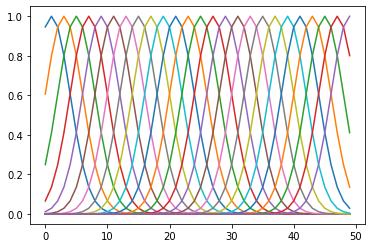

In [3]:
POINTS_NUM = 2 * SAMPLE_SIZE + 1
STD = 3

sample = data[0] #np.reshape(data[0], (len(data[0]), 1))
max_loc = np.argmax(signal.gaussian(POINTS_NUM, std=STD))
gaussians = []
for i in range(0, len(sample), 2):
    start_pos = max_loc - i - 1
    end_pos = start_pos + len(sample)
    values = signal.gaussian(POINTS_NUM, std=STD)[start_pos:end_pos]
    plt.plot(values)
    gaussians.append(values)
plt.show()

In [4]:
X = np.array(gaussians).T
y = sample.copy()
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (50, 25)
y shape: (50,)


In [5]:
lr = Ridge(alpha=0.1)
lr.fit(X, y)

result = [lr.intercept_] * len(sample)
for i in range(len(gaussians)):
    result += lr.coef_[i] * gaussians[i]

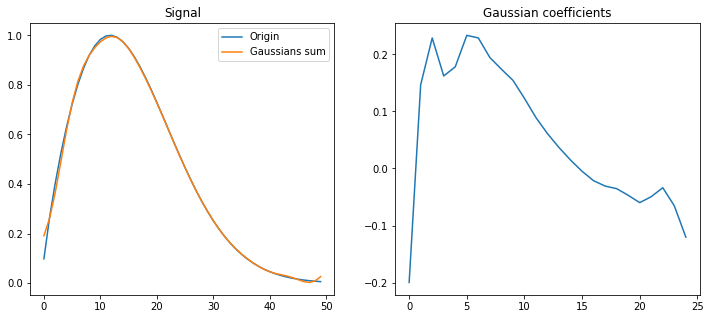

In [6]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title("Signal")
ax[0].plot(y)
ax[0].plot(result)
ax[0].legend(['Origin', 'Gaussians sum'])
ax[1].set_title("Gaussian coefficients")
ax[1].plot(lr.coef_)
plt.show()

In [7]:
id_to_coef = {i: [] for i in range(len(data))}
id_to_intercept = {i: None for i in range(len(data))}

def transform_data(data, lr_alpha=0.1, std=3, coef=2):
    lr = Ridge(alpha=0.1)
    new_data = []
    for i, sample in enumerate(data):
        points_num = 2*len(sample) + 1
        max_loc = np.argmax(signal.gaussian(points_num, std=std))
        gaussians = []
        for j in range(0, len(sample), coef):
            start_pos = max_loc - j - 1
            end_pos = start_pos + len(sample)
            values = signal.gaussian(points_num, std=std)[start_pos:end_pos]
            gaussians.append(values)
            
        cur_X = np.array(gaussians).T
        cur_y = sample.copy()
        lr.fit(cur_X, cur_y)
        id_to_coef[i] = lr.coef_
        id_to_intercept[i] = lr.intercept_
        new_data.append(lr.coef_)
    return new_data

In [8]:
def back_transform_data(data):
    origin_data = []
    for i, sample in enumerate(data):
        result = [id_to_intercept[i]] * SAMPLE_SIZE
        for j in range(len(gaussians)):
            result += id_to_coef[i][j] * gaussians[j]
        origin_data.append(result)
    return origin_data

In [9]:
new_data = transform_data(data)

In [10]:
LATENT_DIM = 10
BATCH_SIZE = 128
NUM_EPOCHS = 500
LEARNING_RATE = 1e-3
PRINT_EACH = 100
VERBOSE = 1
NO_SAVE = True
DEVICE = 'cuda'


dataset = SignalsDataset(new_data)

In [11]:
generator = run_train(dataset, \
          latent_dim=LATENT_DIM, \
          sample_size=len(new_data[0]), \
          learning_rate=LEARNING_RATE, \
          num_epochs=NUM_EPOCHS, \
          batch_size=BATCH_SIZE, \
          print_each=PRINT_EACH, \
          verbose=VERBOSE, \
          no_save=NO_SAVE, \
          device=DEVICE)

RuntimeError: size mismatch, m1: [128 x 10], m2: [100 x 128] at /opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/THC/generic/THCTensorMathBlas.cu:290

In [ ]:
signal = generate_new_signal(generator, device='cuda')
result = [0] * SAMPLE_SIZE
for j in range(len(gaussians)):
    result += signal[j] * gaussians[j]
plt.title("Generated signal")
plt.plot(result - np.min(result))
plt.plot(data[np.random.choice(range(len(data)))])
plt.legend(['Generated', 'Origin'])
plt.show()